# Implementation of SGD with stress as loss function for visualization of temporal graphs

As we have moved all functions to a Python file, we have commented them out here.

In [1]:
from HotVisFunctions import *
from SGDStressFunctions import *
import csv
import pandas as pd

/opt/conda/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Shortest paths of PathData

To be able o use the algorithm also for PathData, we need a function wich returns the distance matrix of a Pathdata object.

In [2]:
''' def shortest_paths_path_data(path_data: pp.PathData):
    """
    Computes the shortest path distances between all pairs of nodes in a PathData object using a second-order model.

    Args:
        path_data (pp.PathData): The `PathData` object containing the nodes for which shortest paths are calculated.

    Returns:
        torch.Tensor: A matrix of shortest path distances between all node pairs, where `dist[i, j]` represents the 
                      shortest path distance from node `i` to node `j`.

    Example:
        >>> dist_matrix = shortest_paths_path_data(path_data)
        >>> print(dist_matrix)
        tensor([[0., 1., 2.],
                [1., 0., 3.],
                [2., 3., 0.]])
    """
    # create second order model
    mo_graph = pp.MultiOrderModel.from_PathData(path_data, max_order=2, cached=True)
    # create distance matrix for all nodes: default value is 'inf'
    dist = torch.full((mo_graph.layers[1].n, mo_graph.layers[1].n), float('inf'))
    # get distances of second order model
    mo_dist, _ = pp.algorithms.shortest_paths.shortest_paths_dijkstra(mo_graph.layers[2])
    # iterate through values adjancecy matrix
    for i in range(mo_dist.shape[0]):
        for j in range(mo_dist.shape[0]):
                # get node ids
                node_i = mo_graph.layers[2].mapping.node_ids[i]
                node_j = mo_graph.layers[2].mapping.node_ids[j]
                if(dist[path_data.mapping.to_idx(node_i[0]), path_data.mapping.to_idx(node_j[1])] > mo_dist[i,j] + 1):
                    # write distance into 'dist'
                    dist[path_data.mapping.to_idx(node_i[0]), path_data.mapping.to_idx(node_j[1])] = mo_dist[i,j] + 1
    
    # insert all distances of length 1
    for node in mo_graph.layers[2].nodes:
        dist[path_data.mapping.to_idx(node[0]), path_data.mapping.to_idx(node[1])] = 1

    # fill diagonals with 0
    torch.Tensor.fill_diagonal_(dist, 0)

    return dist'''

' def shortest_paths_path_data(path_data: pp.PathData):\n    """\n    Computes the shortest path distances between all pairs of nodes in a PathData object using a second-order model.\n\n    Args:\n        path_data (pp.PathData): The `PathData` object containing the nodes for which shortest paths are calculated.\n\n    Returns:\n        torch.Tensor: A matrix of shortest path distances between all node pairs, where `dist[i, j]` represents the \n                      shortest path distance from node `i` to node `j`.\n\n    Example:\n        >>> dist_matrix = shortest_paths_path_data(path_data)\n        >>> print(dist_matrix)\n        tensor([[0., 1., 2.],\n                [1., 0., 3.],\n                [2., 3., 0.]])\n    """\n    # create second order model\n    mo_graph = pp.MultiOrderModel.from_PathData(path_data, max_order=2, cached=True)\n    # create distance matrix for all nodes: default value is \'inf\'\n    dist = torch.full((mo_graph.layers[1].n, mo_graph.layers[1].n), float(\

We test the function from above and the ``` pp.algorithms.temporal_shortest_paths``` on simple examples.

In [3]:
g = pp.Graph.from_edge_list([('a', 'b'), ('b','c'), ('b','d')])
test_path_data = pp.PathData(g.mapping)
test_path_data.append_walk(('a', 'b', 'c'))
test_path_data.append_walk(('b', 'd'))
test_path_data.append_walk(('b', 'a'))

test_temp_graph =pp.TemporalGraph.from_edge_list([('a', 'b', 1), ('b', 'c', 1), ('b', 'a', 2), ('b', 'd', 1)])
dist, _ = pp.algorithms.temporal_shortest_paths(test_temp_graph, 1)
print(dist)
print(test_temp_graph.mapping)
print(shortest_paths_path_data(test_path_data))

100%|██████████| 2/2 [00:00<00:00, 223.95it/s]

[[ 0.  1. inf inf]
 [ 1.  0.  1.  1.]
 [inf inf  0. inf]
 [inf inf inf  0.]]
a -> 0
b -> 1
c -> 2
d -> 3

tensor([[0., 1., 2., inf],
        [1., 0., 1., 1.],
        [inf, inf, 0., inf],
        [inf, inf, inf, 0.]])


It is easy to see, that the functions output correct matrices.

## Implementation of the algorithm

At first, we implement the stress function. It should be able to get torch.nn.Embedding and torch.Tensor as input.

In [4]:
'''def stress_loss(layout: torch.nn.Embedding|torch.Tensor, shortest_path_dist: torch.Tensor) -> float:

    """
    Computes the stress loss between the pairwise distances in a layout and the corresponding shortest path distances.
    It can be used to minimize the difference between the distances of points in a layout and the original distances (e.g., shortest path distances in a graph).

    Args:
        layout (torch.nn.Embedding or torch.Tensor): The layout of nodes, either as an `Embedding` or a 2D tensor.
        dist (torch.Tensor): A tensor of shortest path distances between node pairs in the original graph.

    Returns:
        float: The computed stress loss value.

    Example:
        >>> layout = torch.rand((5, 2))  # Example layout with 5 nodes in 2D space
        >>> dist = torch.rand((5, 5))  # Example shortest path distance matrix
        >>> loss = stress_loss(layout, dist)
        >>> print(loss)
    """

    loss = 0

    if isinstance(layout, torch.nn.Embedding):
        for i in range(layout.num_embeddings):
            for j in range(layout.num_embeddings):
                if j != i:
                    delta = layout(torch.tensor(i)) - layout(torch.tensor(j))
                    distance = torch.norm(delta)
                    loss += ((distance - shortest_path_dist[i, j])/shortest_path_dist[i, j]) ** 2  

    elif isinstance(layout, torch.Tensor):
        for i in range(layout.shape[0]):
            for j in range(layout.shape[0]):
                if j != i:
                    delta = layout[i] - layout[j]
                    distance = torch.norm(delta)
                    loss += ((distance - shortest_path_dist[i, j])/shortest_path_dist[i, j]) ** 2  
    else:
        return None

    return loss/2'''

'def stress_loss(layout: torch.nn.Embedding|torch.Tensor, shortest_path_dist: torch.Tensor) -> float:\n\n    """\n    Computes the stress loss between the pairwise distances in a layout and the corresponding shortest path distances.\n    It can be used to minimize the difference between the distances of points in a layout and the original distances (e.g., shortest path distances in a graph).\n\n    Args:\n        layout (torch.nn.Embedding or torch.Tensor): The layout of nodes, either as an `Embedding` or a 2D tensor.\n        dist (torch.Tensor): A tensor of shortest path distances between node pairs in the original graph.\n\n    Returns:\n        float: The computed stress loss value.\n\n    Example:\n        >>> layout = torch.rand((5, 2))  # Example layout with 5 nodes in 2D space\n        >>> dist = torch.rand((5, 5))  # Example shortest path distance matrix\n        >>> loss = stress_loss(layout, dist)\n        >>> print(loss)\n    """\n\n    loss = 0\n\n    if isinstance(layout,

Then we implement a version using the torch libary. This version slightly differs from the one of paper. This is because the papers version can't be implemented using the classic torch trainingloop. Additionally we implement a version using the adam oprimizer instead of SGD.

In [5]:
'''def SGD_stress_torch(data: pp.TemporalGraph|pp.PathData, iterations: int, delta: int = 1, learning_rate: float = 0.01, initial_positions: torch.Tensor | None = None) -> tuple[dict, bool]:
    """
    Performs stress minimization using stochastic gradient descent (SGD) to optimize the layout of nodes in a graph or path data.

    This method aims to learn a 2D layout for the nodes, such that the pairwise distances between nodes in the layout 
    are as close as possible to the given shortest path distances. It uses a stress function to measure the difference 
    between the layout distances and the original shortest path distances.

    Args:
        data (pp.TemporalGraph or pp.PathData): The input graph or path data to be used for layout optimization.
        iterations (int): The number of iterations for the optimization process.
        delta (int, optional): The temporal window size for paths in temporal graphs. Not considered for Pathdata objects. Default is 1.
        learning_rate (float, optional): The learning rate for the SGD optimizer. Default is 0.01.
        initial_positions (torch.Tensor, optional): The initial 2D positions of the nodes for layout optimization. If None, random positions are used.

    Returns:
        dict: A dictionary with node identifiers as keys and their corresponding 2D layout coordinates as values.
        bool: True, if layout is not random

    Example:
        >>> data = pp.TemporalGraph(...)  # A temporal graph object
        >>> layout = SGD_stress_torch(data, iterations=1000)
        >>> print(layout)
        {'node1': [x1, y1], 'node2': [x2, y2], ...}
    """

    # dependent on input type, get graph for wich we need the layout and distance matrix
    if isinstance(data, pp.TemporalGraph):
        graph = data
        dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)
    elif isinstance(data, pp.PathData):
        graph = pp.MultiOrderModel.from_PathData(data, max_order=1).layers[1]
        dist = shortest_paths_path_data(path_data=data)
    else:
        return {}, False
    
    dist = torch.tensor(dist)
    
    if(torch.isinf(dist).any()):
        print("Error: The graph or PathData isn't connected.")
        positions = torch.rand((graph.n, 2))*100
        layout = {}
        for node in graph.nodes:
            layout[node] = positions[graph.mapping.to_idx(node)].tolist()
        return layout, False

    # initialize embedding
    num_nodes =  graph.n 
    embedding_dim = 2     
    embedding = torch.nn.Embedding(num_nodes, embedding_dim)

    # initialize initial_positions
    if not initial_positions is None:
        with torch.no_grad(): 
            embedding.weight = torch.nn.Parameter(initial_positions)
    else:
        initial_positions = torch.rand((graph.n, 2))*100
        embedding.weight = torch.nn.Parameter(initial_positions)


    # define optimizer and learning rate scheduler
    optimizer = torch.optim.SGD(embedding.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999999)

    # training loop
    for i in range(iterations):
        loss = stress_loss(embedding, dist)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        scheduler.step()

        # show loss
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Loss: {loss.item():.4f}")

    # create layout out of embedding
    layout = {}
    for node in graph.nodes:
        layout[node] = embedding(torch.tensor(graph.mapping.to_idx(node))).tolist()

    return layout, True

def Adam_stress_torch(data: pp.TemporalGraph|pp.PathData, iterations: int, delta: int = 1, learning_rate: float = 0.01, initial_positions: torch.Tensor | None = None):

    """
    Performs stress minimization using the Adam optimizer to optimize the layout of nodes in a graph or path data.

    This method aims to learn a 2D layout for the nodes such that the pairwise distances between nodes in the layout
    are as close as possible to the given shortest path distances. It uses a stress function to measure the difference
    between the layout distances and the original shortest path distances. The Adam optimizer is used for gradient-based 
    optimization of the layout.

    Args:
        data (pp.TemporalGraph or pp.PathData): The input graph or path data to be used for layout optimization.
        iterations (int): The number of iterations for the optimization process.
        delta (int, optional): The temporal window size for paths in temporal graphs. Not considered for Pathdata objects. Default is 1.
        learning_rate (float, optional): The learning rate for the SGD optimizer. Default is 0.01.
        initial_positions (torch.Tensor, optional): The initial 2D positions of the nodes for layout optimization. If None, random positions are used.

    Returns:
        dict: A dictionary with node identifiers as keys and their corresponding 2D layout coordinates as values.
        bool: True, if layout is not random

    Example:
        >>> data = pp.TemporalGraph(...)  # A temporal graph object
        >>> layout = Adam_stress_torch(data, iterations=1000)
        >>> print(layout)
        {'node1': [x1, y1], 'node2': [x2, y2], ...}
    """

    # dependent on input type, get graph for wich we need the layout and distance matrix
    if isinstance(data, pp.TemporalGraph):
        graph = data
        dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)
    elif isinstance(data, pp.PathData):
        graph = pp.MultiOrderModel.from_PathData(data, max_order=1).layers[1]
        dist = shortest_paths_path_data(path_data=data)
    else:
        return {}, False

    dist = torch.tensor(dist)

    if(torch.isinf(dist).any()):
        print("Error: The graph or PathData isn't connected.")
        positions = torch.rand((graph.n, 2))*100
        layout = {}
        for node in graph.nodes:
            layout[node] = positions[graph.mapping.to_idx(node)].tolist()
        return layout, False

    # initialize embedding
    num_nodes =  graph.n 
    embedding_dim = 2     
    embedding = torch.nn.Embedding(num_nodes, embedding_dim)

    # initialize initial_positions
    if not initial_positions is None:
        with torch.no_grad(): 
            embedding.weight = torch.nn.Parameter(initial_positions)
    else:
        initial_positions = torch.rand((graph.n, 2))*100
        embedding.weight = torch.nn.Parameter(initial_positions)


    # define optimizer and lossfunction
    optimizer = torch.optim.Adam(embedding.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999999)

    # training loop
    for i in range(iterations):
        loss = stress_loss(embedding, dist)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        scheduler.step()

        # show loss
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Loss: {loss.item():.4f}")
            
    # create layout out of embedding
    layout = {}
    for node in graph.nodes:
        layout[node] = embedding(torch.tensor(graph.mapping.to_idx(node))).tolist()

    return layout, True'''

'def SGD_stress_torch(data: pp.TemporalGraph|pp.PathData, iterations: int, delta: int = 1, learning_rate: float = 0.01, initial_positions: torch.Tensor | None = None) -> tuple[dict, bool]:\n    """\n    Performs stress minimization using stochastic gradient descent (SGD) to optimize the layout of nodes in a graph or path data.\n\n    This method aims to learn a 2D layout for the nodes, such that the pairwise distances between nodes in the layout \n    are as close as possible to the given shortest path distances. It uses a stress function to measure the difference \n    between the layout distances and the original shortest path distances.\n\n    Args:\n        data (pp.TemporalGraph or pp.PathData): The input graph or path data to be used for layout optimization.\n        iterations (int): The number of iterations for the optimization process.\n        delta (int, optional): The temporal window size for paths in temporal graphs. Not considered for Pathdata objects. Default is 1.\n    

Additionally we implement a version wich follows exactly the paper. Thois one might converge faster in less epochs, but every epoch has longer runtime.

In [6]:
'''def SGD_stress_paper(data: pp.TemporalGraph|pp.PathData, iterations: int, delta:int = 1, initial_positions: torch.Tensor | None = None, learning_rate: float = 0.01, eta: float = 1, decay: float = 0.5) -> tuple[dict, bool]:
    
    """
    Performs stress minimization using Stochastic Gradient Descent (SGD) to optimize the layout of nodes in a graph or path data.

    This method aims to learn a 2D layout for the nodes such that the pairwise distances between nodes in the layout 
    are as close as possible to the given shortest path distances. It uses a stress function to measure the difference 
    between the layout distances and the original shortest path distances. The optimizer updates the node positions 
    iteratively based on the gradient of the stress function.

    The algorithm follows the paper: 
    Börsig, K., Brandes, U., Pasztor, B. (2020). Stochastic Gradient Descent Works Really Well for Stress Minimization. 
    In: Auber, D., Valtr, P. (eds) Graph Drawing and Network Visualization. GD 2020. Lecture Notes in Computer Science(), vol 12590. Springer, Cham. 
    https://doi.org/10.1007/978-3-030-68766-3_2

    Args:
        data (pp.TemporalGraph or pp.PathData): The input graph or path data to be used for layout optimization.
        iterations (int): The number of iterations for the optimization process.
        delta (int, optional): The temporal window size for temporal graphs. Not considered for Pathdata objects. Default is 1.
        initial_positions (torch.Tensor, optional): The initial 2D positions of the nodes for layout optimization. If None, random positions are used.
        learning_rate (float, optional): The learning rate for the SGD optimizer. Default is 0.01.
        eta (float, optional): A scaling factor that affects the step width, based on the shortest path distance. Default is 1.
        decay (float, optional): The decay rate for the learning rate over iterations. Default is 0.5.

    Returns:
        dict: A dictionary with node identifiers as keys and their corresponding 2D layout coordinates as values.
        bool: True, if layout is not random

    Example:
        >>> data = pp.TemporalGraph(...)  # A temporal graph object
        >>> layout = SGD_stress_paper(data, iterations=1000)
        >>> print(layout)
    """

     # dependent on input type, get graph for wich we need the layout and distance matrix
    if isinstance(data, pp.TemporalGraph):
        graph = data
        dist, _ = pp.algorithms.temporal_shortest_paths(graph, delta)
    elif isinstance(data, pp.PathData):
        graph = pp.MultiOrderModel.from_PathData(data, max_order=1).layers[1]
        dist = shortest_paths_path_data(path_data=data)
    else:
        return {}, False
    
    dist = torch.tensor(dist)
    
    if(torch.isinf(dist).any()):
        print("Error: The graph or PathData isn't connected.")
        positions = torch.rand((graph.n, 2))*100
        layout = {}
        for node in graph.nodes:
            layout[node] = positions[graph.mapping.to_idx(node)].tolist()
        return layout, False
    
    # initialize initial_positions if not given
    if initial_positions is None:
        initial_positions = torch.rand((graph.n, 2))*100
    
    positions = torch.clone(initial_positions)

    # get all possible node pairs
    #node_pairs = torch.combinations(torch.arange(graph.n), r=2, with_replacement=False)
    #node_pairs = torch.arange(graph.n).view(1, -1) @ torch.arange(graph.n).view(-1,1)
    node_pairs = torch.cartesian_prod(torch.arange(graph.n), torch.arange(graph.n))
    node_pairs = node_pairs[node_pairs[:, 0] != node_pairs[:, 1]]

    for i in range(iterations):
        # shuffle order of node pairs
        shuffled_pairs = node_pairs[torch.randperm(node_pairs.size(0))]
        # calculate step width (called eta in paper)
        step_width = eta * torch.exp(torch.tensor(-decay * i))

        # iterate through node pairs
        for pair in shuffled_pairs:
            # get distance between pairs
            shortest_path_dist = dist[pair[0], pair[1]]
            # skip if nodes are the same
            if(shortest_path_dist == 0):
               continue
            # calculate learning rate
            learning_rate = min(1, ((1 / (shortest_path_dist ** 2)) * step_width)) / 2
            # calculate distance of nodes in layout (not in graph)
            norm = torch.norm(positions[pair[0]] - positions[pair[1]])
            # determine distace and dirction the nodes are moved 
            delta = (norm - shortest_path_dist) / norm * (positions[pair[0]] - positions[pair[1]])
            positions[pair[0]] -= learning_rate * delta
            positions[pair[1]] += learning_rate * delta

        # show loss
        if (i+1) % 10 == 0:
            print(f"Epoch [{i+1}/{iterations}], Stress: {stress_loss(positions, dist):.4f}")

    # create layout 
    layout = {}
    for node in graph.nodes:
        layout[node] = positions[graph.mapping.to_idx(node)].tolist()

    return layout, True'''

'def SGD_stress_paper(data: pp.TemporalGraph|pp.PathData, iterations: int, delta:int = 1, initial_positions: torch.Tensor | None = None, learning_rate: float = 0.01, eta: float = 1, decay: float = 0.5) -> tuple[dict, bool]:\n    \n    """\n    Performs stress minimization using Stochastic Gradient Descent (SGD) to optimize the layout of nodes in a graph or path data.\n\n    This method aims to learn a 2D layout for the nodes such that the pairwise distances between nodes in the layout \n    are as close as possible to the given shortest path distances. It uses a stress function to measure the difference \n    between the layout distances and the original shortest path distances. The optimizer updates the node positions \n    iteratively based on the gradient of the stress function.\n\n    The algorithm follows the paper: \n    Börsig, K., Brandes, U., Pasztor, B. (2020). Stochastic Gradient Descent Works Really Well for Stress Minimization. \n    In: Auber, D., Valtr, P. (eds) Graph Dr

## Test

Next we test the algorithms on a graph

In [7]:
graph = pp.io.read_csv_temporal_graph('graphs/synthetic_graph/temporal_clusters_real_kregular.tedges', is_undirected = True, timestamp_format='%S')
# read colors
colors = {}
with open('graphs/synthetic_graph/colors.csv', mode="r") as file:
    reader = csv.reader(file)
    next(reader)  # Überspringt die Kopfzeile
    for row in reader:
        number, color = row
        colors[number] = color
style = {}
style['node_color'] = colors
style['node_size'] = 10
style['edge_size'] = 0.1

In [8]:
layout_paper = SGD_stress_paper(graph, iterations=30, delta = 1, learning_rate=0.01)
layout_adam = Adam_stress_torch(graph, iterations=500, delta = 1, learning_rate=0.5)
layout_torch = SGD_stress_torch(graph, iterations=100, delta = 1, learning_rate=0.01)

100%|██████████| 20000/20000 [00:08<00:00, 2302.11it/s]


Epoch [10/30], Stress: 66.9177
Epoch [20/30], Stress: 66.8969
Epoch [30/30], Stress: 66.8968


100%|██████████| 20000/20000 [00:08<00:00, 2376.24it/s]


Epoch [10/500], Loss: 1157896.8106
Epoch [20/500], Loss: 824959.4406
Epoch [30/500], Loss: 572936.0885
Epoch [40/500], Loss: 389926.9867
Epoch [50/500], Loss: 260645.6273
Epoch [60/500], Loss: 171430.2162
Epoch [70/500], Loss: 111092.0027
Epoch [80/500], Loss: 70972.3773
Epoch [90/500], Loss: 44674.8710
Epoch [100/500], Loss: 27661.1111
Epoch [110/500], Loss: 16803.7427
Epoch [120/500], Loss: 9989.7073
Epoch [130/500], Loss: 5803.8885
Epoch [140/500], Loss: 3295.7220
Epoch [150/500], Loss: 1834.9410
Epoch [160/500], Loss: 1009.3388
Epoch [170/500], Loss: 556.8580
Epoch [180/500], Loss: 316.2772
Epoch [190/500], Loss: 191.9641
Epoch [200/500], Loss: 129.3231
Epoch [210/500], Loss: 98.3755
Epoch [220/500], Loss: 83.2424
Epoch [230/500], Loss: 75.8093
Epoch [240/500], Loss: 72.0739
Epoch [250/500], Loss: 70.1142
Epoch [260/500], Loss: 69.0203
Epoch [270/500], Loss: 68.3623
Epoch [280/500], Loss: 67.9364
Epoch [290/500], Loss: 67.6445
Epoch [300/500], Loss: 67.4366
Epoch [310/500], Loss: 6

100%|██████████| 20000/20000 [00:08<00:00, 2411.40it/s]


Epoch [10/100], Loss: 69.1861
Epoch [20/100], Loss: 67.0778
Epoch [30/100], Loss: 66.8634
Epoch [40/100], Loss: 66.7825
Epoch [50/100], Loss: 66.7432
Epoch [60/100], Loss: 66.7235
Epoch [70/100], Loss: 66.7115
Epoch [80/100], Loss: 66.7028
Epoch [90/100], Loss: 66.6961
Epoch [100/100], Loss: 66.6907


All algorithms cnverge to a similar value. This is an indicator that they work.

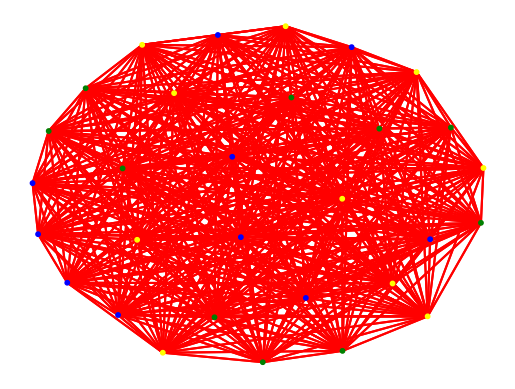

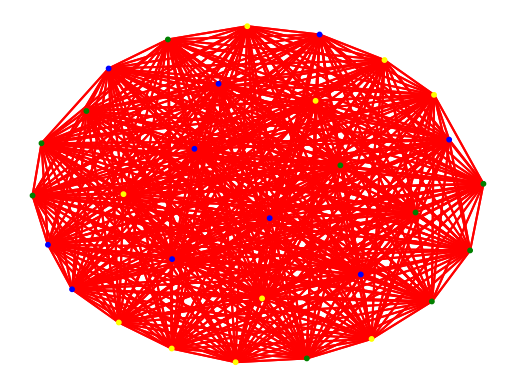

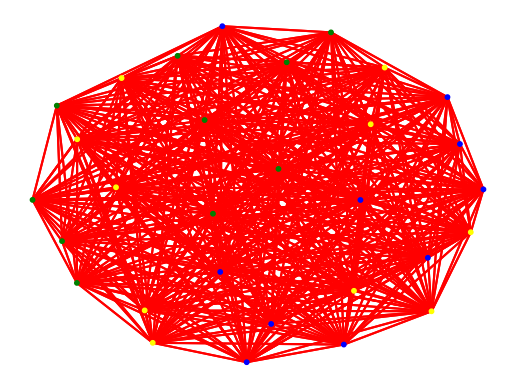

In [9]:
pp.plot(graph.to_static_graph(), layout=layout_adam, backend='matplotlib', **style)
pp.plot(graph.to_static_graph(), layout=layout_torch, backend='matplotlib', **style)
pp.plot(graph.to_static_graph(), layout=layout_paper, backend='matplotlib', **style)

In [10]:
# load graph
office_graph = pp.io.read_csv_temporal_graph('graphs/office/network/edges.csv', is_undirected = True, timestamp_format='%S')
# load metadata
meta_data = pd.read_csv("graphs/office/network/nodes.csv")

colors = {}
color_map = {'DSE': 'yellow', 'DMCT': 'green', 'DISQ': 'blue', 'SRH':'pink', 'SFLE':'black'}
for index, row in meta_data.iterrows():
        colors[f"{row['index']}"] = color_map[row['department']]
style = {}
style['node_color'] = colors
style['node_size'] = 10
style['edge_size'] = 0.1
style['edge_opacity'] = 1

Next we test the algorithms on path data.

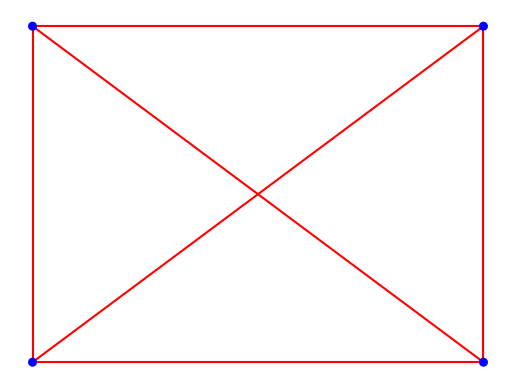

In [11]:
tedges = [('a', 'b', 1), ('b', 'c', 3), ('d', 'c', 4)]
test_graph = pp.TemporalGraph.from_edge_list(tedges)
test_layout= {'a':[0,0], 'b':[1,0], 'c':[0,1], 'd':[1,1]}

# create PathData object with same structure
test_paths = pp.PathData(test_graph.mapping)


test_paths.append_walk(['a', 'b', 'd', 'c', 'a', 'b', 'd'])
test_paths.append_walk(['a', 'd', 'b', 'c'])


test_m = pp.MultiOrderModel.from_PathData(test_paths, 2, cached=True)
pp.plot(test_m.layers[1], layout=test_layout, backend="matplotlib")

In [13]:
layout_paper = SGD_stress_paper(test_paths, iterations=30, delta = 1, learning_rate=0.01)
layout_adam = Adam_stress_torch(test_paths, iterations=500, delta = 1, learning_rate=0.5)
layout_torch = SGD_stress_torch(test_paths, iterations=100, delta = 1, learning_rate=0.01)

Epoch [10/30], Stress: 1.5336
Epoch [20/30], Stress: 1.5290
Epoch [30/30], Stress: 1.5290
Epoch [10/500], Loss: 6757.8081
Epoch [20/500], Loss: 4203.0811
Epoch [30/500], Loss: 2494.3052
Epoch [40/500], Loss: 1393.8278
Epoch [50/500], Loss: 705.3685


/workspaces/pathpyG/src/pathpyG/visualisations/Project_JS/SGDStressFunctions.py:214: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.tensor(dist, device=device)


Epoch [60/500], Loss: 316.9200
Epoch [70/500], Loss: 125.4344
Epoch [80/500], Loss: 42.9293
Epoch [90/500], Loss: 12.3300
Epoch [100/500], Loss: 3.1899
Epoch [110/500], Loss: 1.2585
Epoch [120/500], Loss: 1.0711
Epoch [130/500], Loss: 1.0772
Epoch [140/500], Loss: 1.0267
Epoch [150/500], Loss: 0.9600
Epoch [160/500], Loss: 0.9245
Epoch [170/500], Loss: 0.9169
Epoch [180/500], Loss: 0.9146
Epoch [190/500], Loss: 0.9118
Epoch [200/500], Loss: 0.9104
Epoch [210/500], Loss: 0.9100
Epoch [220/500], Loss: 0.9099
Epoch [230/500], Loss: 0.9098
Epoch [240/500], Loss: 0.9098
Epoch [250/500], Loss: 0.9098
Epoch [260/500], Loss: 0.9098
Epoch [270/500], Loss: 0.9098
Epoch [280/500], Loss: 0.9098
Epoch [290/500], Loss: 0.9098
Epoch [300/500], Loss: 0.9098
Epoch [310/500], Loss: 0.9098
Epoch [320/500], Loss: 0.9098
Epoch [330/500], Loss: 0.9098
Epoch [340/500], Loss: 0.9098
Epoch [350/500], Loss: 0.9098
Epoch [360/500], Loss: 0.9098
Epoch [370/500], Loss: 0.9098
Epoch [380/500], Loss: 0.9098
Epoch [3

/workspaces/pathpyG/src/pathpyG/visualisations/Project_JS/SGDStressFunctions.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.tensor(dist, device=device)


Epoch [60/100], Loss: 41.9591
Epoch [70/100], Loss: 16.6880
Epoch [80/100], Loss: 7.1166
Epoch [90/100], Loss: 3.4534
Epoch [100/100], Loss: 2.0351


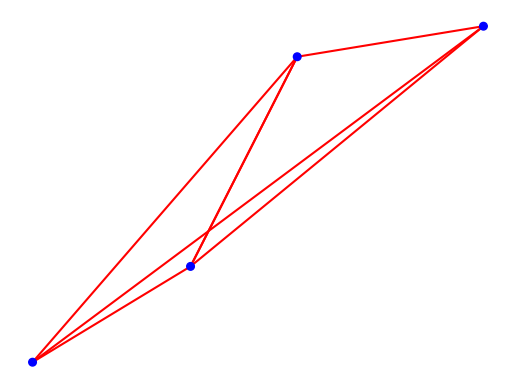

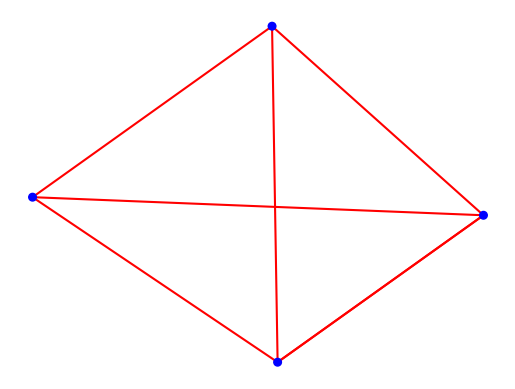

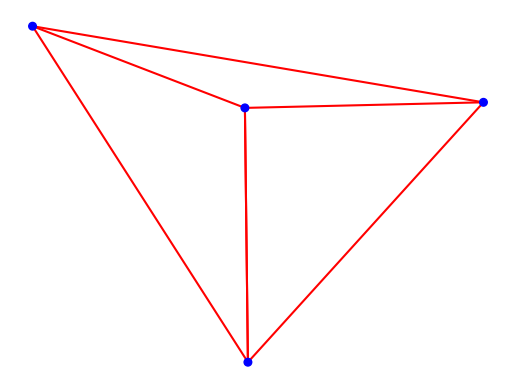

In [14]:
pp.plot(test_m.layers[1], layout=layout_paper, backend="matplotlib")
pp.plot(test_m.layers[1], layout=layout_adam, backend="matplotlib")
pp.plot(test_m.layers[1], layout=layout_torch, backend="matplotlib")